In [1]:
# %load_ext cudf.pandas
# %load_ext cuml.accel

In [2]:
import torch
import sys
import os
import gc

import joblib
import pickle
# import cudf
# from cuml import ForestInference

## -- DATA MANIPUALATION --
import numpy as np
import pandas as pd
import random

## -- VISUALISATION --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import shap

## -- FUNCTIONAL TOOLS --
from google.colab import files
from itertools import combinations
from tqdm.notebook import tqdm
from time import time

# ## SCIKIT-LEARN
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import (
                LogisticRegression, Lasso, LassoCV,
                Ridge, RidgeCV, ElasticNet, ElasticNetCV
)
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
                train_test_split, cross_val_score, GridSearchCV,
                KFold, StratifiedKFold, RepeatedStratifiedKFold
)
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, PolynomialFeatures
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay
from sklearn.feature_selection import mutual_info_regression, SequentialFeatureSelector as SFS1
from mlxtend.feature_selection import SequentialFeatureSelector as SFS2

# -- GBDTs --
import xgboost as xgb
import lightgbm as lgb

try:
    import catboost as cgb
    # import optuna
except:
    %pip install -qq -U catboost # optuna
    import catboost as cgb
    # import optuna

import warnings

In [3]:
np.__version__, sns.__version__

('1.26.4', '0.12.2')

In [4]:
##### --- GLOBAL SETTINGS --- #####
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', None)
# plt.style.use("ggplot")

## -- Set Global Seed --
SEED = 42
def set_global_seed(seed = SEED):
    """Sets the global random seed for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)

set_global_seed()

## -- Set Device-Agnostic code --
USE_cud = "cuda" if torch.cuda.is_available() else "cpu"
USE_gpu = "gpu" if torch.cuda.is_available() else "cpu"
USE_GPU = "GPU" if torch.cuda.is_available() else "CPU"

COLOR = '\033[36m'
RESET = '\033[0m'

# from google.colab import data_table
# data_table.enable_dataframe_formatter()

In [5]:
PATH       = "/kaggle/input/playground-series-s5e9/"
train      = pd.read_csv(PATH+"train.csv", index_col='id') #.drop('id', axis=1)
test       = pd.read_csv(PATH+"test.csv", index_col='id') #.drop('id', axis=1)

orig = pd.read_csv("/kaggle/input/bpm-prediction-challenge/Train.csv")
orig['id'] = np.arange(len(orig))
orig.set_index('id', inplace=True)

submit     = pd.read_csv(PATH+"sample_submission.csv")

TARGET     = 'BeatsPerMinute'
FEATURES   = test.columns.tolist()

In [6]:
display(train.head())
train.info()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
id,,,,,,,,,,
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


<class 'pandas.core.frame.DataFrame'>
Index: 524164 entries, 0 to 524163
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   RhythmScore                524164 non-null  float64
 1   AudioLoudness              524164 non-null  float64
 2   VocalContent               524164 non-null  float64
 3   AcousticQuality            524164 non-null  float64
 4   InstrumentalScore          524164 non-null  float64
 5   LivePerformanceLikelihood  524164 non-null  float64
 6   MoodScore                  524164 non-null  float64
 7   TrackDurationMs            524164 non-null  float64
 8   Energy                     524164 non-null  float64
 9   BeatsPerMinute             524164 non-null  float64
dtypes: float64(10)
memory usage: 44.0 MB


In [7]:
display(test.head())
test.info()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
id,,,,,,,,,
524164,0.410013,-16.794967,0.023500,0.232910,0.012689,0.271585,0.664321,302901.5498,0.424867
524165,0.463071,-1.357000,0.141818,0.057725,0.257942,0.097624,0.829552,221995.6643,0.846000
524166,0.686569,-3.368928,0.167851,0.287823,0.210915,0.325909,0.304978,357724.0127,0.134067
524167,0.885793,-5.598049,0.118488,0.000005,0.376906,0.134435,0.487740,271790.3989,0.316467
524168,0.637391,-7.068160,0.126099,0.539073,0.068950,0.024300,0.591248,277728.5383,0.481067


<class 'pandas.core.frame.DataFrame'>
Index: 174722 entries, 524164 to 698885
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   RhythmScore                174722 non-null  float64
 1   AudioLoudness              174722 non-null  float64
 2   VocalContent               174722 non-null  float64
 3   AcousticQuality            174722 non-null  float64
 4   InstrumentalScore          174722 non-null  float64
 5   LivePerformanceLikelihood  174722 non-null  float64
 6   MoodScore                  174722 non-null  float64
 7   TrackDurationMs            174722 non-null  float64
 8   Energy                     174722 non-null  float64
dtypes: float64(9)
memory usage: 13.3 MB


In [8]:
display(orig.head())
orig.info()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
id,,,,,,,,,,
0,0.513080,-7.811659,0.071013,0.064564,0.109495,0.316042,0.736929,328639.3188,0.556200,117.092439
1,0.775393,-6.819409,0.023500,0.510599,0.187498,0.024361,0.259488,271967.9826,0.410533,122.002279
2,0.636408,-19.782248,0.063451,0.427861,0.002226,0.024300,0.054848,186147.0029,0.533333,149.130616
3,0.232190,-14.957299,0.023500,0.076268,0.000001,0.228454,0.744650,321734.9723,0.658533,95.832178
4,0.758564,-4.715966,0.023500,0.263551,0.414794,0.197167,0.966592,179973.3982,0.230467,125.696263


<class 'pandas.core.frame.DataFrame'>
Index: 14633 entries, 0 to 14632
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   RhythmScore                14633 non-null  float64
 1   AudioLoudness              14633 non-null  float64
 2   VocalContent               14633 non-null  float64
 3   AcousticQuality            14633 non-null  float64
 4   InstrumentalScore          14633 non-null  float64
 5   LivePerformanceLikelihood  14633 non-null  float64
 6   MoodScore                  14633 non-null  float64
 7   TrackDurationMs            14633 non-null  float64
 8   Energy                     14633 non-null  float64
 9   BeatsPerMinute             14633 non-null  float64
dtypes: float64(10)
memory usage: 1.2 MB


In [9]:
train.describe()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
count,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000
mean,0.632843,-8.379014,0.074443,0.262913,0.117690,0.178398,0.555843,241903.692949,0.500923,119.034899
std,0.156899,4.616221,0.049939,0.223120,0.131845,0.118186,0.225480,59326.601501,0.289952,26.468077
min,0.076900,-27.509725,0.023500,0.000005,0.000001,0.024300,0.025600,63973.000000,0.000067,46.718000
25%,0.515850,-11.551933,0.023500,0.069413,0.000001,0.077637,0.403921,207099.876625,0.254933,101.070410
50%,0.634686,-8.252499,0.066425,0.242502,0.074247,0.166327,0.564817,243684.058150,0.511800,118.747660
75%,0.739179,-4.912298,0.107343,0.396957,0.204065,0.268946,0.716633,281851.658500,0.746000,136.686590
max,0.975000,-1.357000,0.256401,0.995000,0.869258,0.599924,0.978000,464723.228100,1.000000,206.037000


In [10]:
# Check if column names are the same regardless of order
are_same_set = set(train.columns) == set(orig.columns)
print(f"Are column names the same regardless of order (train vs test)? {are_same_set}")

# Check if column names are exactly the same and in the same order
are_same_exact = train.columns.equals(orig.columns)
print(f"Are column names exactly the same and in the same order (train vs train)? {are_same_exact}")

Are column names the same regardless of order (train vs test)? True
Are column names exactly the same and in the same order (train vs train)? True


In [11]:
## -- Unique value counts for each dataset --
TRAIN_UNIQUE = {}
ORIGINAL_UNIQUE = {}
TEST_UNIQUE = {}

for col in test.columns:
    TRAIN_UNIQUE[col] = train[col].nunique()
    ORIGINAL_UNIQUE[col] = orig[col].nunique()
    TEST_UNIQUE[col] = test[col].nunique()

unique_counts_df = pd.concat(
        [pd.DataFrame(TRAIN_UNIQUE, index=['Train']),
         pd.DataFrame(ORIGINAL_UNIQUE, index=['Original']),
         pd.DataFrame(TEST_UNIQUE, index=['Test'])],
        )

unique_counts_df.style.background_gradient(cmap='Spectral')

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
Train,322528,310411,229305,270478,218979,279591,306504,377442,11606
Original,14354,13311,10892,11833,9435,12283,13689,14567,14633
Test,116151,110402,84370,97364,79221,101149,109993,133624,10465


### FEATURE ENGINEERING

In [12]:
def plot_feature_distributions(df: pd.DataFrame, features: list[str]):
    """
    Generates histograms and box plots for a list of features in a DataFrame.

    Args:
        df: Pandas DataFrame containing the data.
        features: List of column names to plot.
        figsize: Tuple specifying the figure size.  Adjust the height based on the number of features.
    """

    num_features = len(features)
    fig, axs = plt.subplots(num_features, 2, figsize=(20, len(features)*6//1.5))
    fig.tight_layout(pad=3.0) 

    for i, feature in enumerate(features):
        # Histogram with KDE
        ax1 = axs[i, 0]
        sns.distplot(
                a=df[feature], ax=ax1,
                hist_kws={'color':'lightgreen', "edgecolor": 'k'},
                kde_kws={"color": 'r'}
        )
        ax1.set_title(f'Distribution of {feature}')
        ax1.set_xlabel("")
        ax1.set_ylabel('Frequency')

        # Box plot
        ax2 = axs[i, 1]
        ax2.boxplot(
                df[feature], vert=False, patch_artist=True,
                boxprops={'facecolor': 'lightgreen'}
        )
        ax2.set_title(f'Box Plot of {feature}')
        ax2.set_xlabel("")
        ax2.set_yticks([])

    plt.show()

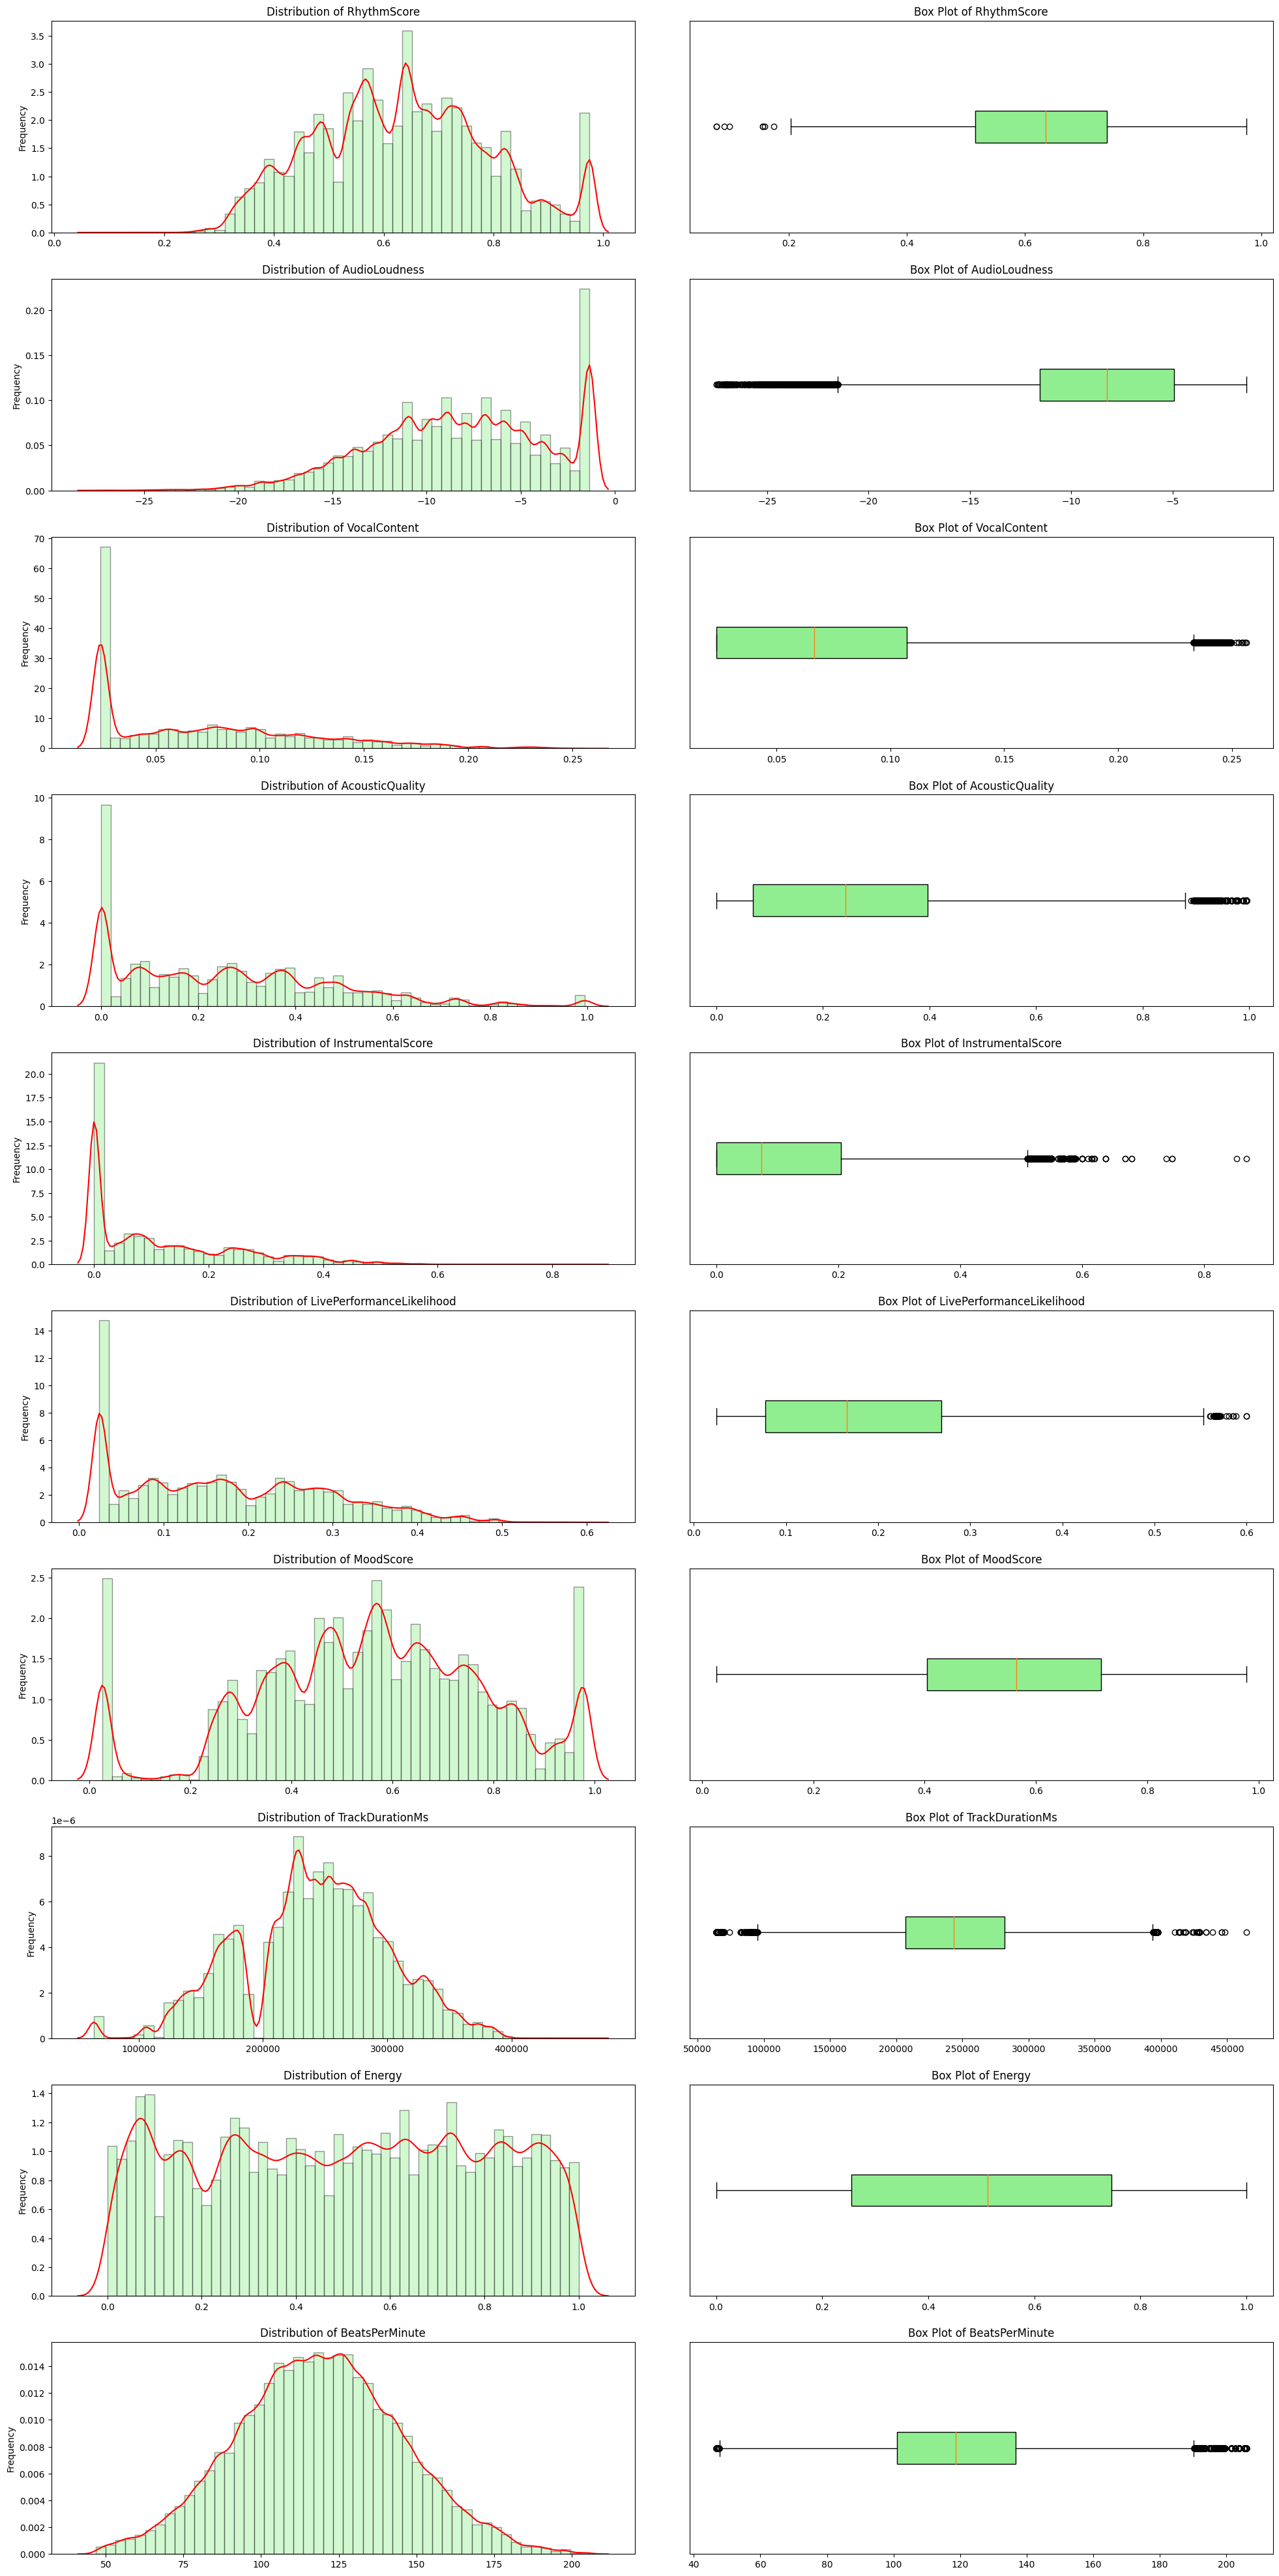

In [13]:
plot_feature_distributions(train, train.columns)

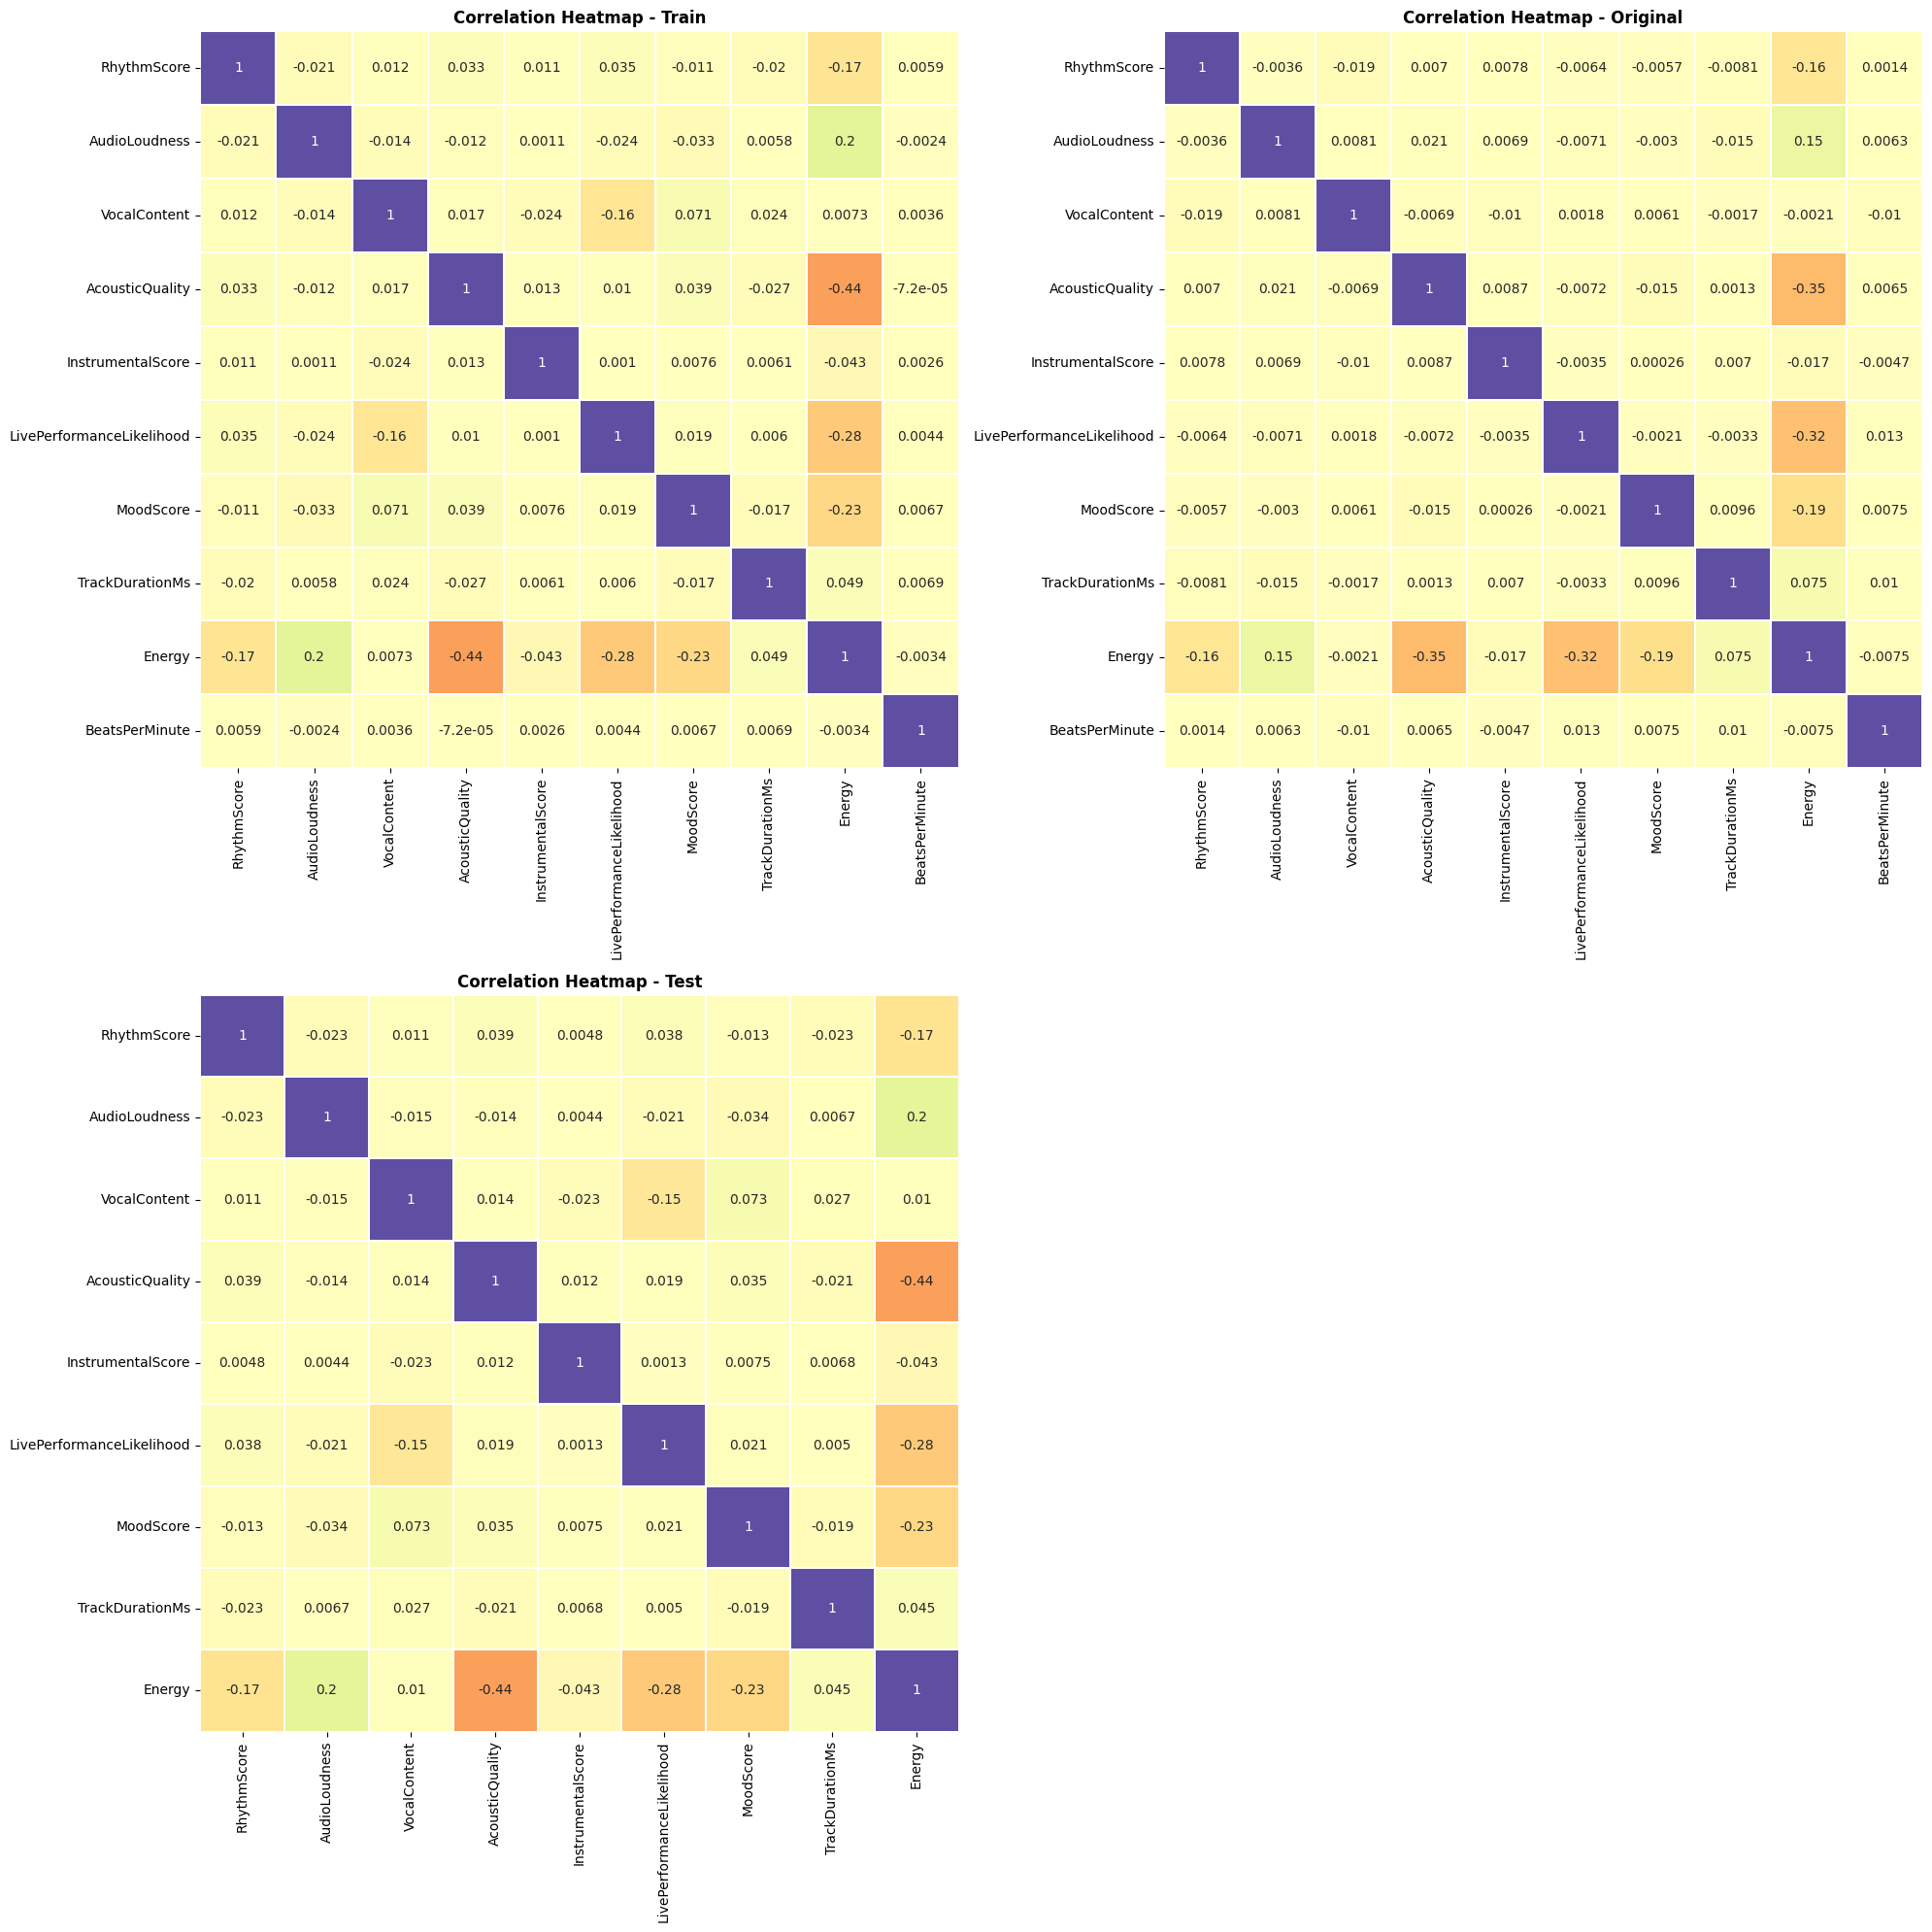

In [14]:
plt.figure(figsize=(20, 20))
for i, df in enumerate([train,orig,test]):
    plt.subplot(2, 2, i + 1)
    sns.heatmap(
        data=df.corr('spearman'), cmap='Spectral',
        annot=True, center=0, linewidths=0.1, cbar=False,
        )
    plt.xticks(rotation=90)
    dataset_names = ['Train', 'Original', 'Test']
    plt.title(f"Correlation Heatmap - {dataset_names[i]}", fontweight='semibold')

plt.tight_layout()
plt.show()

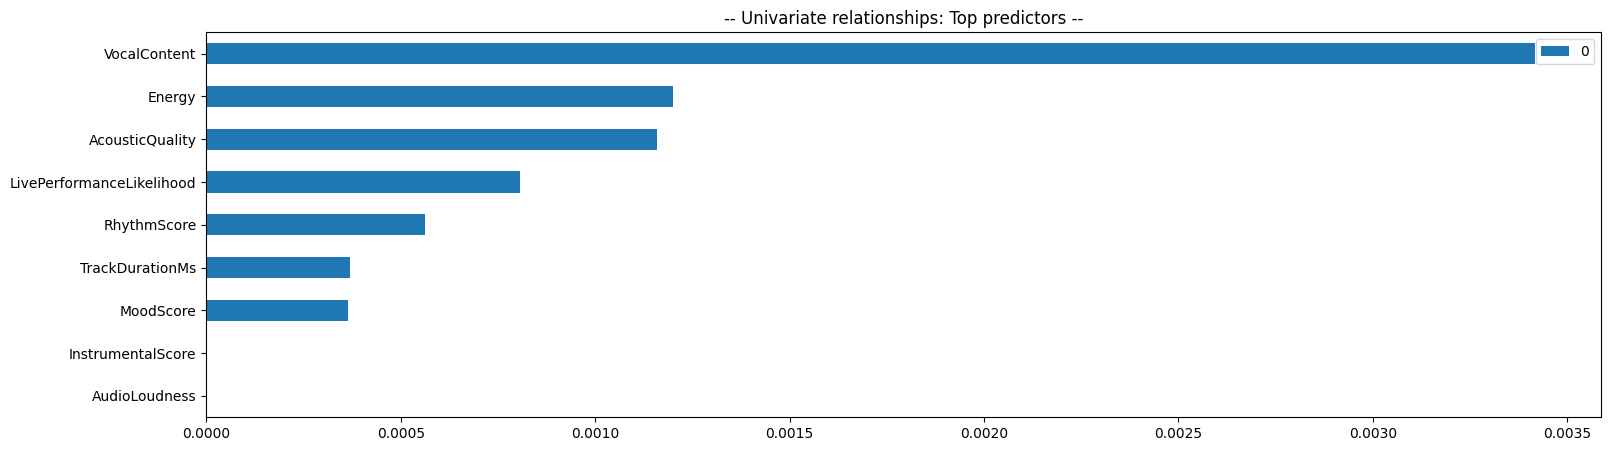

CPU times: user 1min 4s, sys: 439 ms, total: 1min 5s
Wall time: 1min 5s


In [15]:
%%time
## -- Univariate relationships between features and target --
mutual_info = mutual_info_regression(train[FEATURES], train[TARGET], random_state=SEED)
mutual_dict = dict(zip(train.drop(TARGET, axis=1).columns.to_list(), list(mutual_info)))
mutual_info_df = pd.DataFrame.from_dict(mutual_dict, orient='index').sort_values(by=0)

mutual_info_df.plot.barh(figsize=(18, 5))
plt.title("-- Univariate relationships: Top predictors --")
# plt.tight_layout()
plt.show()

### PROFILE REPORT

In [16]:
# %%capture
# # -- Comprehensive EDA --
# !{sys.executable} -m pip install -U ydata-profiling[notebook]
# !pip install jupyter-contrib-nbextensions
# !jupyter nbextension enable --py widgetsnbextension

In [17]:
# from ydata_profiling import ProfileReport, compare

In [18]:
# ## -- Single EDA --
# profile_df = ProfileReport(train, title="Insights into y Types", explorative=True)
# profile_df.to_notebook_iframe()

In [19]:
# profile_df.to_file("Beats_EDA_Report.html")

In [20]:
# ## -- Create Pofiles for Datasets --
# train_report = ProfileReport(train, title="Train")
# test_report = ProfileReport(test, title="Test")
# orig_report = ProfileReport(orig, title="Original")

In [21]:
## -- Compare 2 Datasets --
# comparison_report = train_report.compare(orig_report)

In [22]:
# comparison_report.to_notebook_iframe()

In [23]:
# comparison_report = train_report.compare(test_report)
# comparison_report.to_notebook_iframe()

In [24]:
# comparison_report.to_file("Beats_Comparison_EDA_Report.html")

In [25]:
## -- Compare 2++ Datasets --
# comparison_report = compare([train_report, orig1_report])

# Obtain merged statistics
# statistics = comparison_report.get_description()
# Save report to file
# comparison_report.to_file("Train_Orig_Comparisons.html")
# comparison_report

# ML TRAINING

In [26]:
# params = {
#     'colsample_bylevel': 0.21416299403295808,
#     'colsample_bynode': 0.6208356380953189,
#     'colsample_bytree': 0.19219680400212635,
#     # 'early_stopping_rounds': 200,
#     'eval_metric': "auc",
#     'gamma': 0.6051664515971382,
#     'max_bin': 682,
#     'max_delta_step': 5.264818337431145,
#     'max_depth': 68,
#     'min_child_weight': 5.23408291542125,
#     'n_estimators': 10000,
#     'n_jobs': -1,
#     'objective': "binary:logistic",
#     'random_state': SEED,
#     'reg_alpha': 0.46516016901463414,
#     'reg_lambda': 0.8410553418334902,
#     'subsample': 0.802533192662325,
#     'verbosity': 0
# }

In [27]:
## -- DEFINE MODELS -- ##
models = {
    'XGB': xgb.XGBRegressor(#**xgb_0,
                            eval_metric='rmse', random_state=SEED,
                            # n_estimators=1000, #learning_rate=0.05, max_depth=0,
                            # reg_alpha=2.5, reg_lambda=1.0, min_child_weight=1.5, 
                            # # subsample=0.85, colsample_bytree=0.5, colsample_bynode=0.5,
                            # early_stopping_rounds=50, # enable_categorical=True,
                            verbosity=0, n_jobs=3, device=USE_cud,
    ),
    'LGBM': lgb.LGBMRegressor(#**lgb_1,
                            metric='rmse', random_state=SEED, 
                            device=USE_gpu, n_jobs=3, verbose=-1, 
                            # n_estimators=1000, learning_rate=0.02, max_depth=8,
                            # reg_alpha=1.5, reg_lambda=1.0, min_child_weight=1.5, 
    ),
    'CAT': cgb.CatBoostRegressor(#**cgb_0,
                            eval_metric='RMSE', random_state=SEED, verbose=0,
                            allow_writing_files=False, task_type=USE_GPU, thread_count=3,
                            # n_estimators=1000, # learning_rate=0.02, depth=8, l2_leaf_reg=2.0,
                            # min_child_samples=1.5, # cat_features=cat_cols,
    ),
    'HGB': HistGradientBoostingRegressor(#**hist_0,
                            scoring='neg_root_mean_squared_error', random_state=SEED, verbose=0,
                            # max_iter=1000, #learning_rate=0.005, l2_regularization=0.01, max_depth=6, 
                            # n_iter_no_change=200, #categorical_features=cat_cols,
    ),
    # 'RForest': RandomForestRegressor(
    #                         n_estimators=1000, #max_depth=8,
    #                         random_state=SEED, n_jobs=-1
    # ),
    # # 'Logistic': LogisticRegression(
    # #                         #**logit_0,
    # #                         max_iter = 2000, random_state = SEED, n_jobs=-1,
    # #  ),
    # 'nn_MLP': MLPRegressor(#**mlp_0,
    #                     alpha=0.01, max_iter=1000,
    #                     # hidden_layer_sizes=(128, 64),
    #                     # n_iter_no_change=100, random_state=SEED,
    #  ),
}

print(f"Number of models: {len(models)}")
print(models.keys())

Number of models: 4
dict_keys(['XGB', 'LGBM', 'CAT', 'HGB'])


TRAINING MODELS:   0%|          | 0/4 [00:00<?, ?it/s]


[1] XGB ████████████████████████████████████████
	Fold 1 AUC: 26.532725
	Fold 2 AUC: 26.597187
	Fold 3 AUC: 26.591622
	Fold 4 AUC: 26.646662
	Fold 5 AUC: 26.507215
	Fold 6 AUC: 26.451472
	Fold 7 AUC: 26.702084
	Fold 8 AUC: 26.510724
	Fold 9 AUC: 26.565290
	Fold 10 AUC: 26.501215
|----------------------------------------------------
|  Overall OOF AUC: 26.560716
| Average Fold AUC: 26.560620 ± 0.071622


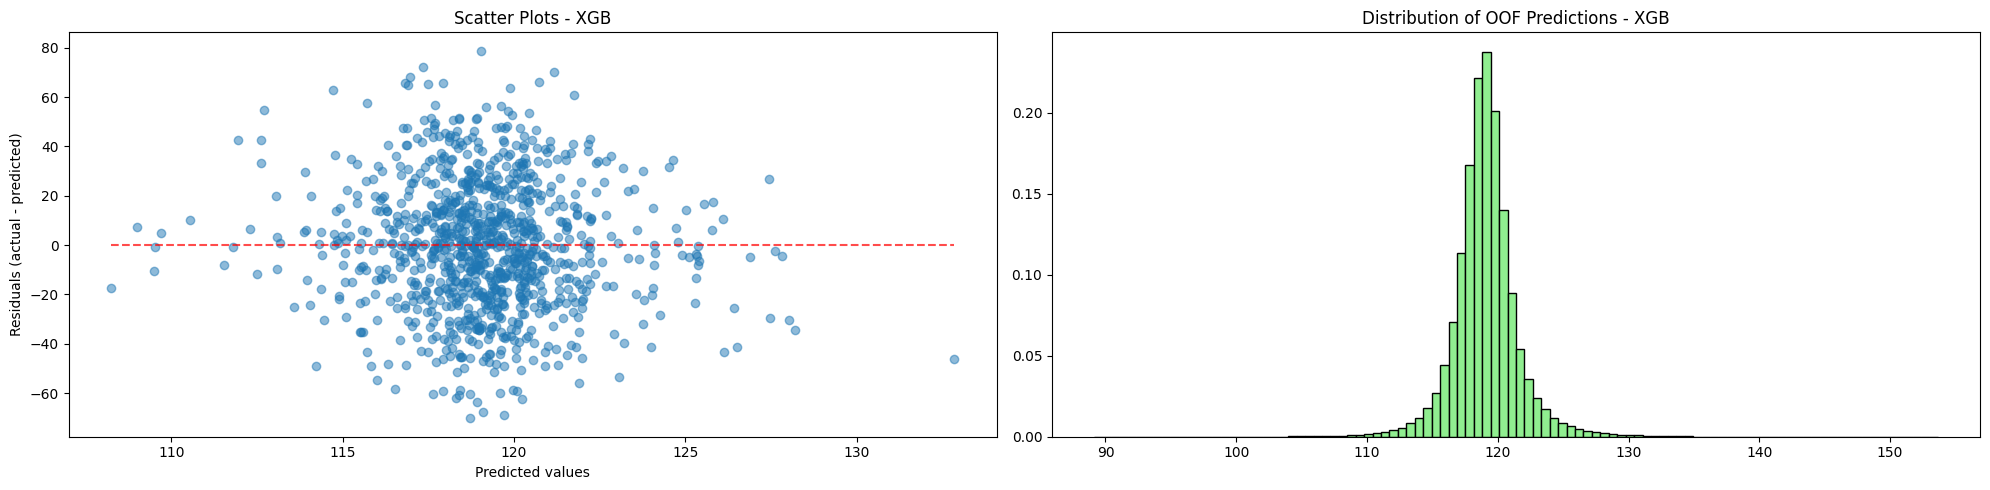

Computation Time: 26.64 secs ##########################################################################################

[2] LGBM ████████████████████████████████████████
	Fold 1 AUC: 26.461380
	Fold 2 AUC: 26.466248
	Fold 3 AUC: 26.508454
	Fold 4 AUC: 26.548471
	Fold 5 AUC: 26.424908
	Fold 6 AUC: 26.347781
	Fold 7 AUC: 26.596474
	Fold 8 AUC: 26.433861
	Fold 9 AUC: 26.468410
	Fold 10 AUC: 26.408710
|----------------------------------------------------
|  Overall OOF AUC: 26.466556
| Average Fold AUC: 26.466470 ± 0.067551


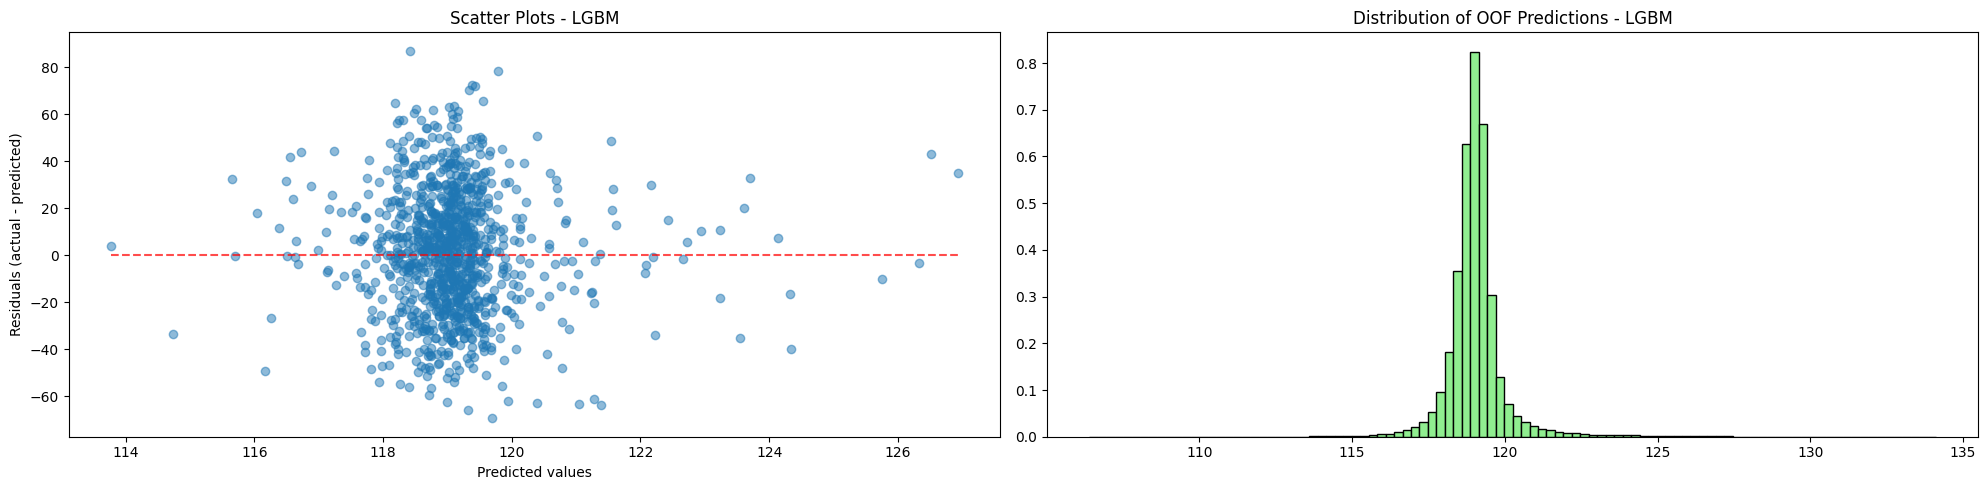

Computation Time: 20.10 secs ##########################################################################################

[3] CAT ████████████████████████████████████████
	Fold 1 AUC: 26.494095
	Fold 2 AUC: 26.504726
	Fold 3 AUC: 26.551135
	Fold 4 AUC: 26.580110
	Fold 5 AUC: 26.468010
	Fold 6 AUC: 26.387297
	Fold 7 AUC: 26.629962
	Fold 8 AUC: 26.453831
	Fold 9 AUC: 26.505138
	Fold 10 AUC: 26.450480
|----------------------------------------------------
|  Overall OOF AUC: 26.502562
| Average Fold AUC: 26.502479 ± 0.066524


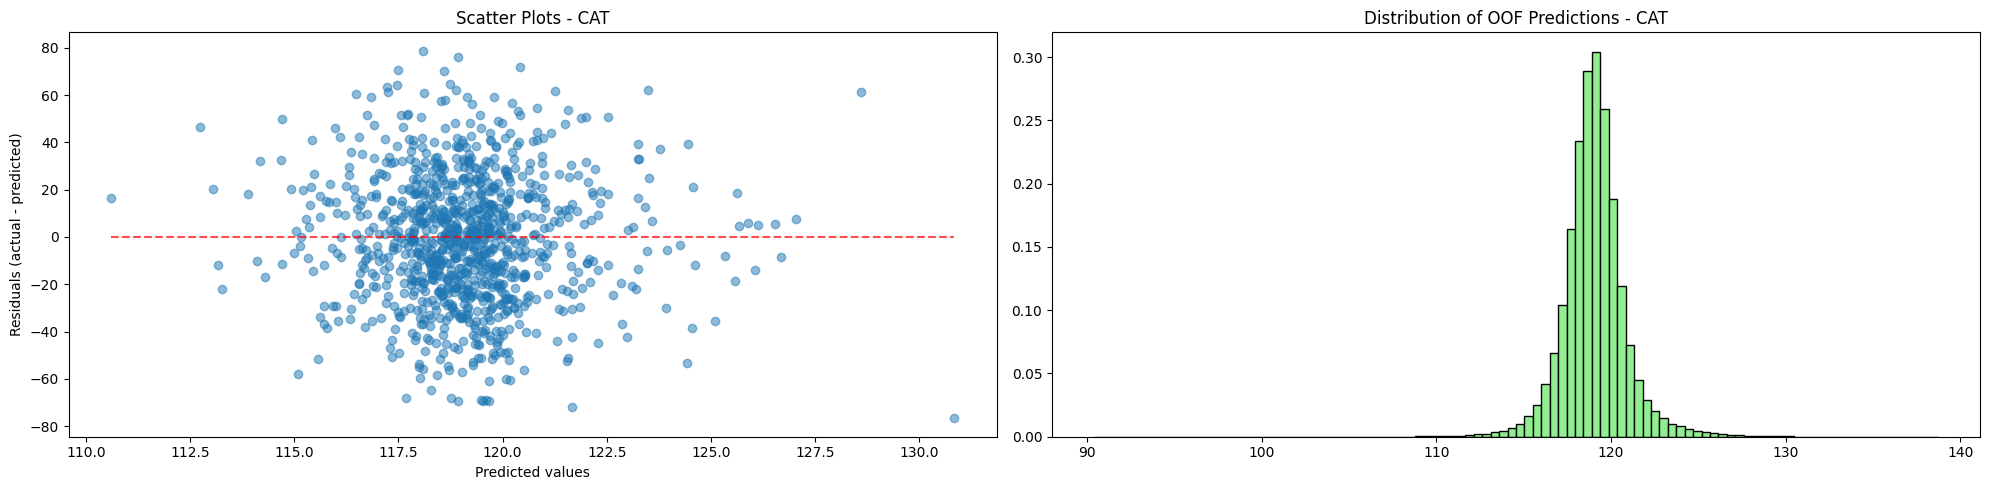

Computation Time: 350.69 secs ##########################################################################################

[4] HGB ████████████████████████████████████████
	Fold 1 AUC: 26.453330
	Fold 2 AUC: 26.465750
	Fold 3 AUC: 26.501553
	Fold 4 AUC: 26.544765
	Fold 5 AUC: 26.422937
	Fold 6 AUC: 26.340650
	Fold 7 AUC: 26.587199
	Fold 8 AUC: 26.428944
	Fold 9 AUC: 26.462445
	Fold 10 AUC: 26.406105
|----------------------------------------------------
|  Overall OOF AUC: 26.461452
| Average Fold AUC: 26.461368 ± 0.066816


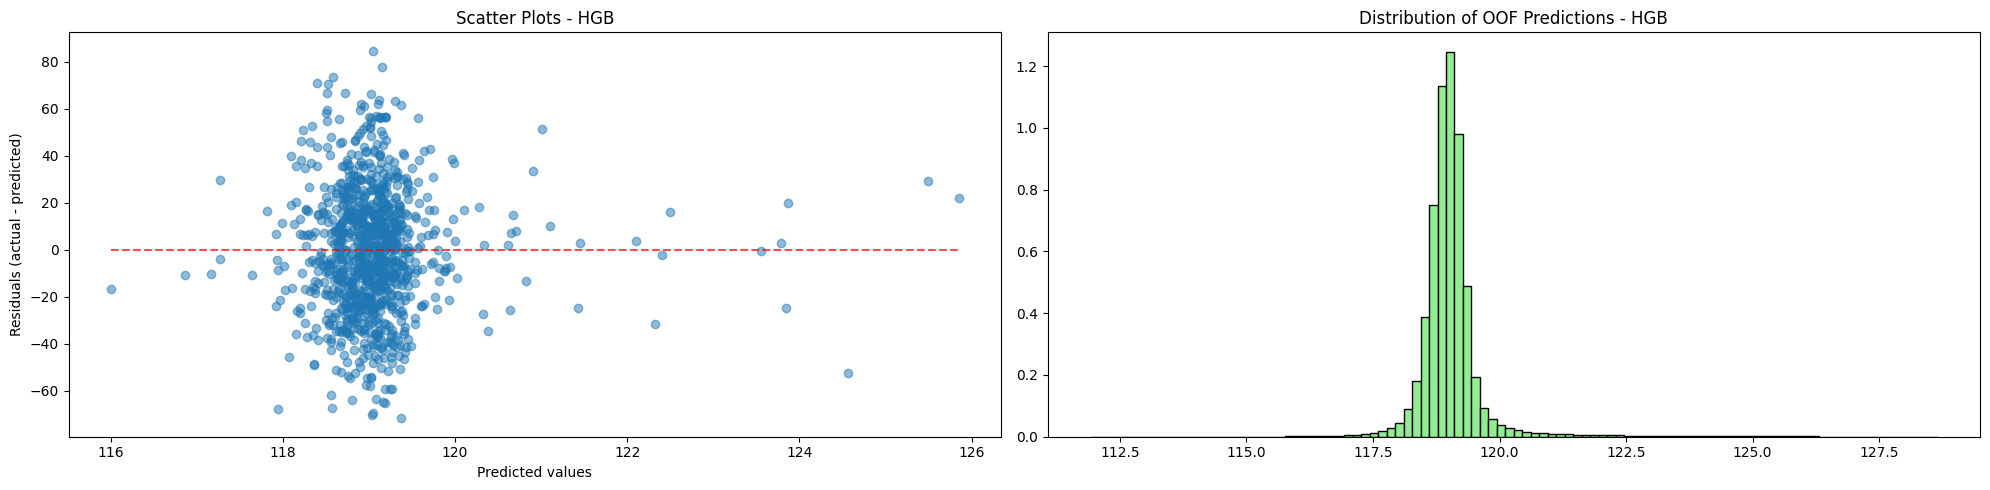

Computation Time: 21.00 secs ##########################################################################################


In [28]:
## -- DEFINE TRAINING PARAMETERS -- ##
## ----------------------------------------------------------------------
## -- Split data --
X = train.drop(TARGET, axis=1)
y = train[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=SEED)

oof_final_df = pd.DataFrame()
test_final_df = pd.DataFrame()

E_STOP = 100
FOLDS = 10
MODELS_FIT = {}

kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

## -- INITIATE TRAINING -- ##
## -----------------------------------------------------------------------
for i, (name, model) in tqdm(enumerate(models.items()), total=len(models), desc="TRAINING MODELS"):
    print(f"\n[{i+1}] {COLOR}{name} {'█'*40}{RESET}")
    tik = time()

    oof_preds = np.zeros(len(X_train))
    test_preds = np.zeros(len(test))
    fold_RMSEs = []

    model = make_pipeline(RobustScaler().set_output(transform="pandas"), model)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
        model.fit(X_train_fold, y_train_fold,
                  # early_stopping_rounds=E_STOP,
                  # eval_set=[(X_val_fold, y_val_fold)],
                  # verbose=200,
        )
        y_fold_pred = model.predict(X_val_fold)
        oof_preds[val_idx] = y_fold_pred

        # Predict on test set (accumulate final prediction)
        test_proba = model.predict(test)
        test_preds += test_proba / FOLDS

        # Compute RMSE for validation fold
        fold_rmse = mean_squared_error(y_val_fold, y_fold_pred, squared=False)
        fold_RMSEs.append(fold_rmse)

        print(f"\tFold {fold+1} AUC: {fold_rmse:.6f}")

    ## -- After all folds:
    overall_RMSE = mean_squared_error(y_train, oof_preds, squared=False)
    print(f"|{'-'*52}")
    print(f"{COLOR}|  Overall OOF AUC: {overall_RMSE:.6f}")
    print(f"| Average Fold AUC: {np.mean(fold_RMSEs):.6f} ± {np.std(fold_RMSEs):.6f}{RESET}")
    ## -- Plot ROC CURVE --
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    display = PredictionErrorDisplay.from_predictions(
        y_train, oof_preds, ax=ax1,
        kind="residual_vs_predicted",
        scatter_kwargs={"alpha": 0.5},
        line_kwargs={'color': 'r'},
    )
    ax1.set_title(f"Scatter Plots - {name}")
    # -----------------------------------------------------
    plt.hist(oof_preds, bins=100, density=True, ec='k', color='lightgreen')
    ax2.set_title(f"Distribution of OOF Predictions - {name}") 
    # -----------------------------------------------------
    for ax in (ax1, ax2):
        ax.grid(False)
    plt.tight_layout() 
    plt.show()

    oof_final_df[name]  = oof_preds
    test_final_df[name] = test_preds
    MODELS_FIT[name]    = model

    tok = time()
    tiktok = tok-tik
    print(f"Computation Time: {tiktok:.2f} secs {'#'*90}")

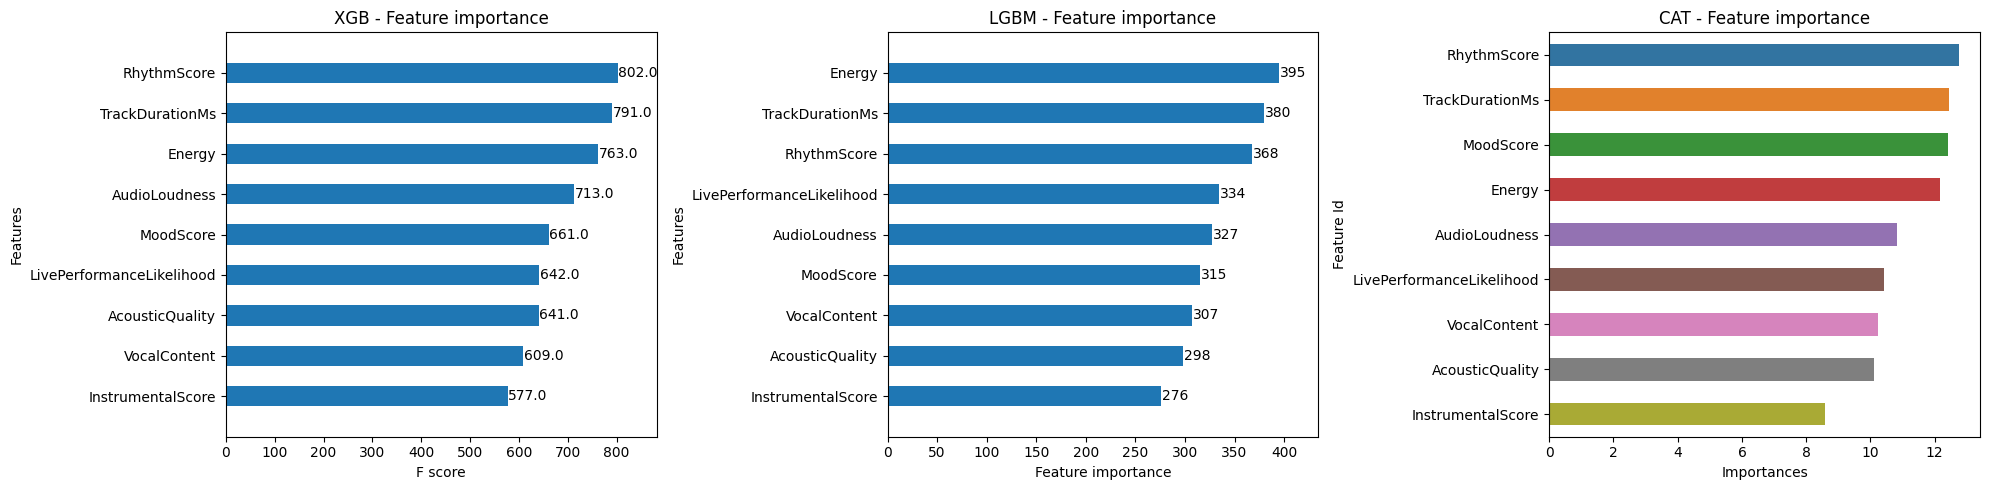

In [29]:
## -- PLOT FEATURES IMPORTANCES -- 
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

## -- XGBoost -- 
xgb.plot_importance(MODELS_FIT['XGB'][1],
                    ax=ax[0], grid=False, height=.5,
                    title="XGB - Feature importance")

## -- LightGBM -- 
lgb.plot_importance(MODELS_FIT['LGBM'][1],
                    ax=ax[1], grid=False, height=.5, precision=0,
                    title="LGBM - Feature importance")

## -- CatBoost -- 
cat_imp_df = MODELS_FIT['CAT'][1].get_feature_importance(prettified=True)
sns.barplot(data=cat_imp_df, x='Importances', y='Feature Id', width=.5, ax=ax[2])
ax[2].set_title('CAT - Feature importance')

plt.tight_layout()
plt.show()

 98%|===================| 12816/13104 [00:21<00:00]       

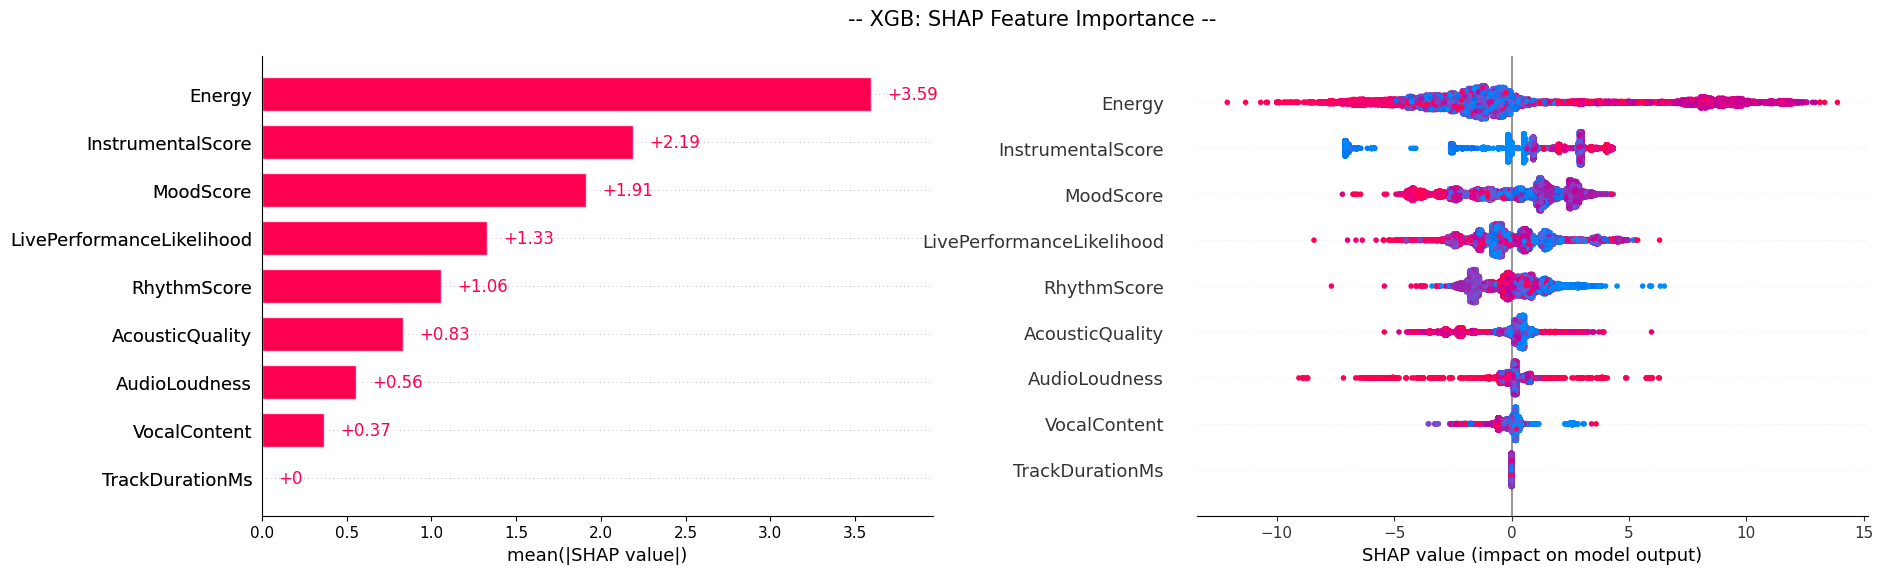

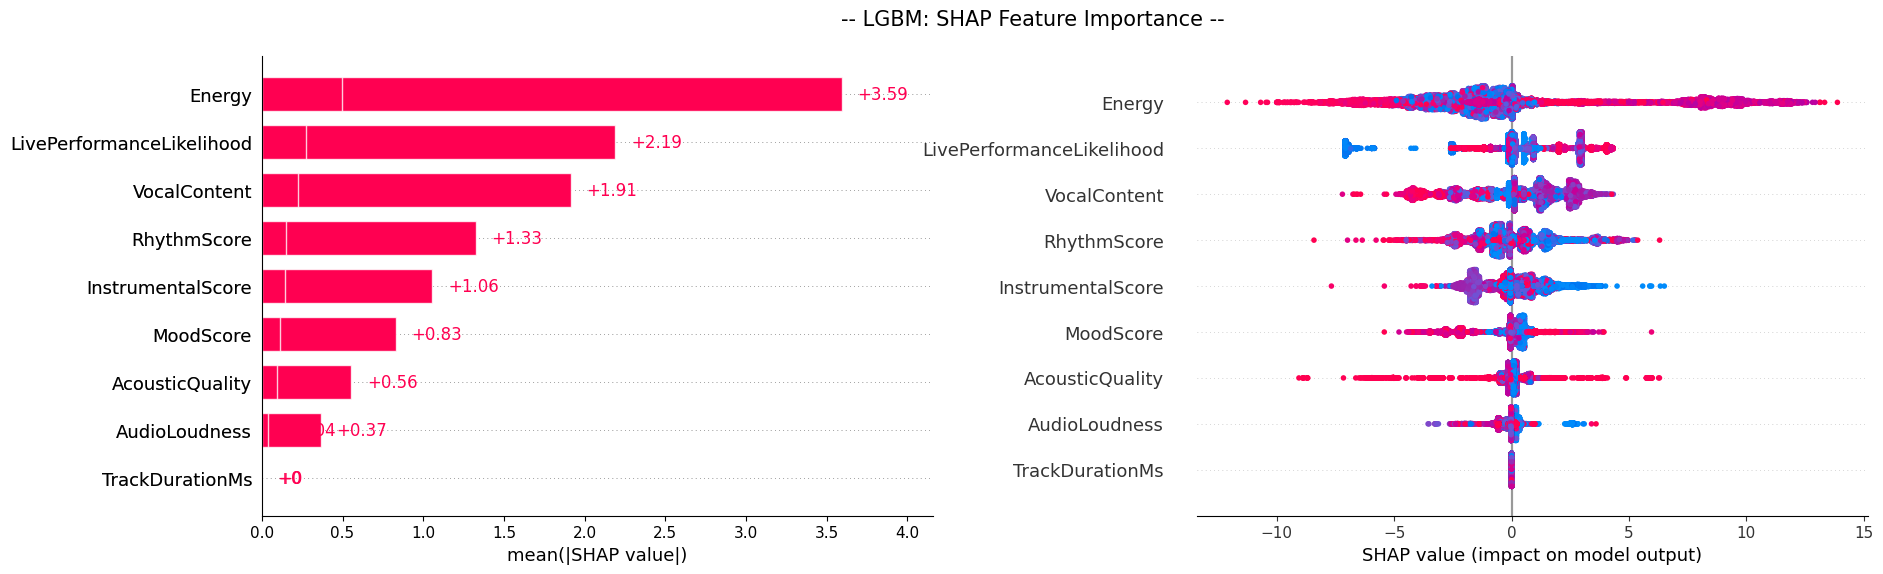

100%|===================| 13075/13104 [05:23<00:00]       

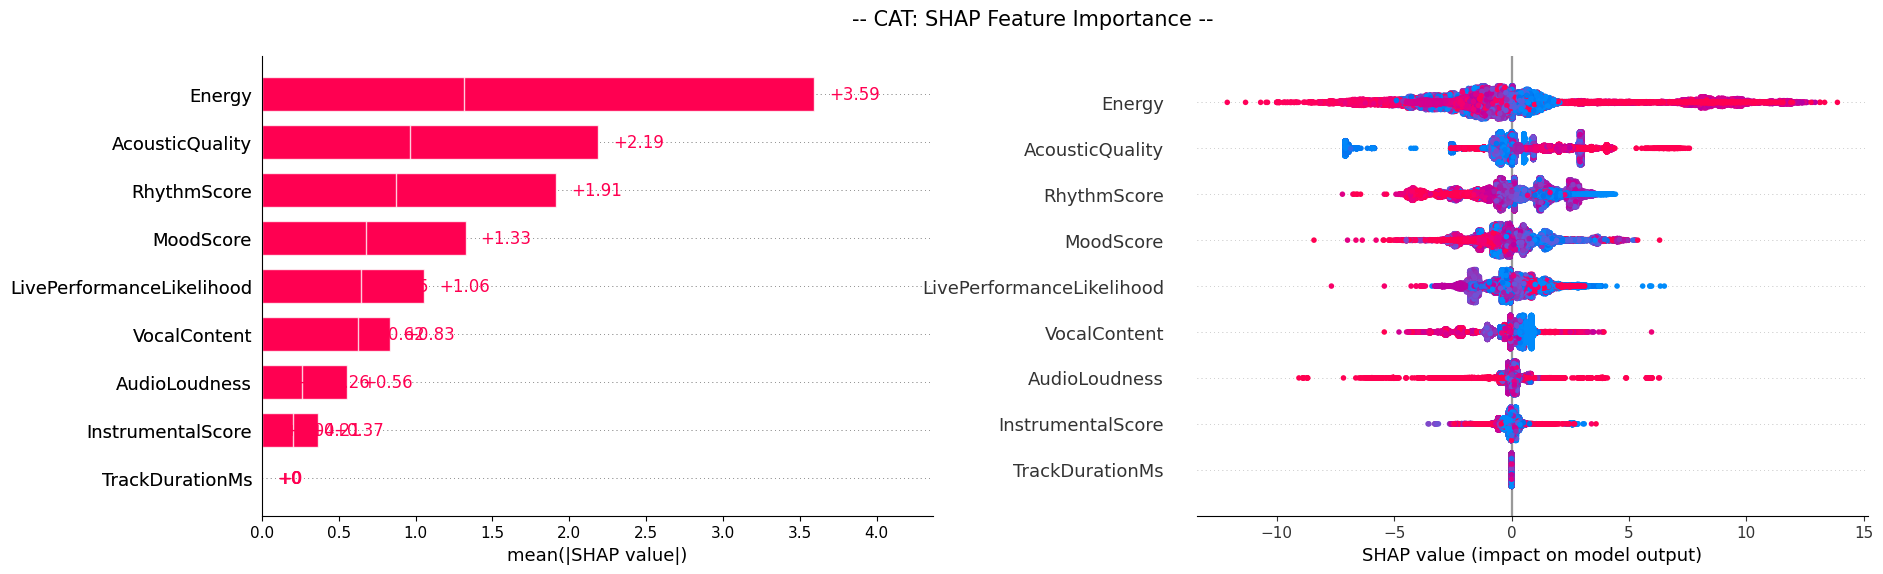

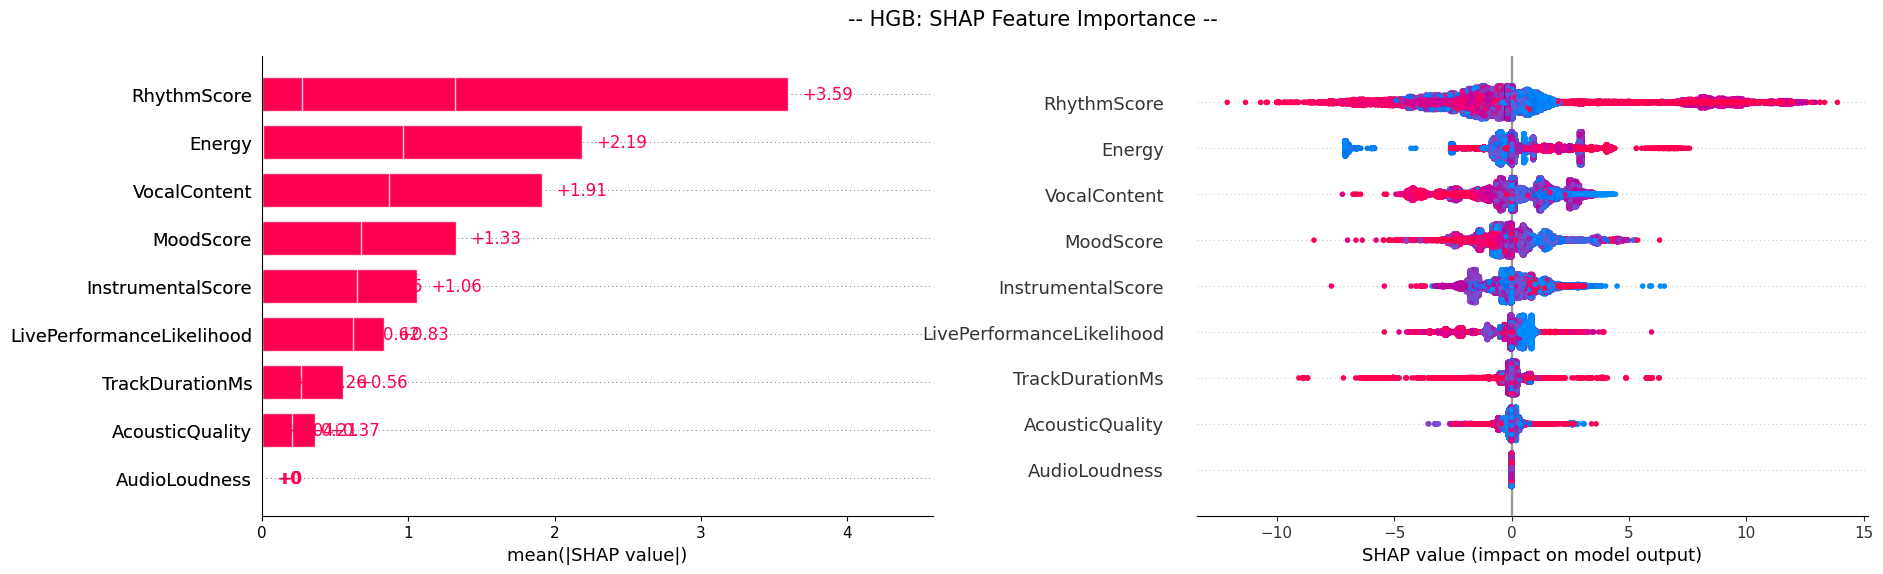

In [30]:
fig, ax = plt.subplots(1, 2)
fig.tight_layout(pad=3.0)

for i, (name, model) in enumerate(MODELS_FIT.items()):
    explainer = shap.TreeExplainer(model[1], X_test)
    shap_values = explainer(X_test.sample(frac=0.5))

    plt.sca(ax[0]) 
    shap.plots.bar(shap_values, show=False)

    plt.sca(ax[1]) 
    shap.plots.beeswarm(shap_values, show=False, plot_size=(20, 6), color_bar=False)

    plt.suptitle(f"-- {name}: SHAP Feature Importance --", fontsize=15)
    plt.show()
    print("\n")

# plt.tight_layout()